In [2]:
%cd ..

/home/fabris/wok/geo_latte


/home/fabris/miniconda3/envs/spline/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [1]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from core import utils, geodesics, generative_models, manifolds

In [2]:
seed = 42
# seed everything
torch.backends.cudnn.deterministic = True
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Generate the data
params = {'N': 2000, 'data_type': 3, 'sigma': 0.1, 'extra_dims': 2}
data, labels = utils.generate_data(params)
data.shape, labels.shape

((2000, 5), (2000, 1))

Text(0.5, 0.92, 'Only the signal in the data')

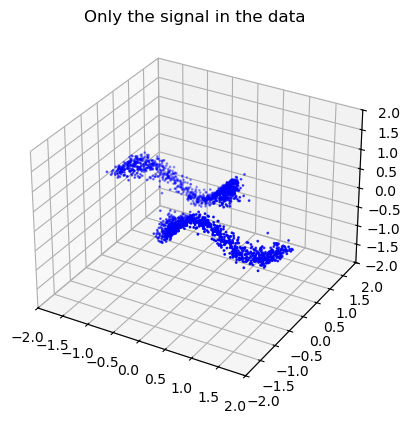

In [6]:
# Plot the data
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='b', s=1)
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
plt.title('Only the signal in the data')

In [8]:
# The parameters of the model
d = 2  # The latent space dimension
N_data, D = data.shape
activFunName = 'tanh'  # tanh used in the synthetics
activations_list = {
    'softplus': torch.nn.Softplus(),
    'tanh': torch.nn.Tanh()
}
activFun = activations_list[activFunName]
H = 32
lambda_reg = 1e-8  # For the weights of the networks
epochs = 500
learning_rate = 1e-3  # 0.0001 works for MNIST and 0.1 for the synthetic
clipping_value = 1
batch_size = 128
warmup = int(0.35 * epochs)

In [9]:
# Use PCA to get the linear extrapolation
A_gen, L_gen, b_gen = utils.my_pca(data, d)
A_gen = A_gen @ np.diag(np.sqrt(L_gen))  # Project based on Probabilistic PCA: N(0, 1) -> data

# Construct the VAE
VAE_model = generative_models.VariationalAutoEncoder_GELS(D=D, d=d, H=H, activFun=activFun, A_init=A_gen, b_init=b_gen)
VAE_model.to(device)
VAE_optimizer = torch.optim.Adam(VAE_model.parameters(), lr=learning_rate)

In [12]:
# Train the VAE
ELBO = np.zeros((epochs, 1))
for epoch in range(epochs):
    # Permute the indices of the train data
    permutation = np.random.permutation(N_data)

    # Initialize the losses
    train_loss = 0
    train_loss_num = 0

    # Train for all the batches
    for i in range(0, N_data, batch_size):
        indices = permutation[i:i + batch_size]
        X_batch = torch.from_numpy(data[indices, :].astype(np.float32)) # batch_indices x D
        X_batch = X_batch.to(device)

        # The VAE
        MU_X_eval, LOG_VAR_X_eval, Z_ENC_eval, MU_Z_eval, LOG_VAR_Z_eval = VAE_model(X_batch)

        # Compute the regularization parameter
        if warmup == 0:
            r = 0
        else:
            r = 1. * epoch / warmup
            if r > 1.:
                r = 1.

        loss = generative_models.VAE_loss_GELS(x=X_batch, mu_x=MU_X_eval, log_var_x=LOG_VAR_X_eval,
                                               mu_z=MU_Z_eval, log_var_z=LOG_VAR_Z_eval, anneal_param=r)

        # Update the parameters
        VAE_optimizer.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), clipping_value)
        VAE_optimizer.step()

        # Collect the ways
        train_loss += loss.item()
        train_loss_num += 1

    ELBO[epoch] = train_loss / train_loss_num

    if epoch % 20 == 0:
        print("[Epoch: {}/{}] [objective: {:.3f}]".format(epoch, epochs, ELBO[epoch, 0]))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)